In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.datasets import mnist

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [4]:
X_train = X_train/255
X_train = X_train.reshape(-1,28,28,1) * 2. - 1.

In [5]:
X_train.min()

-1.0

In [6]:
X_train.max()

1.0

In [7]:
only_zeros = X_train[y_train == 0]

In [8]:
only_zeros.shape

(5923, 28, 28, 1)

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Reshape,Dropout,LeakyReLU,Flatten,BatchNormalization,Conv2D,Conv2DTranspose

In [10]:
np.random.seed(42)
tf.random.set_seed(42)
codings_size = 100

In [11]:
generator = Sequential()

generator.add(Dense(7*7*128, input_shape=[codings_size]))
generator.add(Reshape([7,7,128]))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding="same",
                                activation='relu'))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(1, kernel_size=5, strides=2, padding="same",
                                activation='tanh'))


In [12]:
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, padding="same",
                         activation=LeakyReLU(0.3),
                         input_shape=[28,28,1]))
discriminator.add(Dropout(0.5))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding='same',
                         activation=LeakyReLU(0.3)))
discriminator.add(Dropout(0.5))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))

In [13]:
GAN = Sequential([generator,discriminator])

In [14]:
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.trainable = False

In [15]:
GAN.compile(loss='binary_crossentropy',optimizer='adam')

In [16]:
GAN.layers

In [17]:
GAN.layers[0].summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6272)              633472    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 128)         512       
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        204864    
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 1)         1601      
Total params: 840,705
Trainable params: 840,321
Non-trainable params: 384
________________________________________________

In [18]:
GAN.layers[1].summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6273      
Total params: 212,865
Trainable params: 0
Non-trainable params: 212,865
________________________________________________

In [19]:
batch_size = 32

In [20]:
my_data = only_zeros

In [21]:
dataset = tf.data.Dataset.from_tensor_slices(my_data).shuffle(buffer_size=1000)

In [22]:
type(dataset)

tensorflow.python.data.ops.dataset_ops.ShuffleDataset

In [23]:
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [24]:
epochs = 20

In [28]:
generator, discriminator = GAN.layers

for epoch in range(epochs):
    print(f"Currently on Epoch {epoch+1}")
    i = 0

    for X_batch in dataset:
        i = i+1
        if i % 20 == 0:
            print(f"\tCurrently on batch number {i} of {len(my_data)//batch_size}")

        # TRAINING DISCRIMINATOR

        noise = tf.random.normal(shape=[batch_size, codings_size])

        gen_images = generator(noise)

        X_fake_vs_real = tf.concat([gen_images, tf.dtypes.cast(X_batch,tf.float32)], axis=0)

        y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)

        discriminator.trainable = True

        discriminator.train_on_batch(X_fake_vs_real,y1)


        # TRAINING GENERATOR
        noise = tf.random.normal(shape=[batch_size, codings_size])

        y2 = tf.constant([[1.]] * batch_size)

        discriminator.trainable = True

        GAN.train_on_batch(noise, y2)

print("TRAINING COMPLETE")


Currently on Epoch 1
	Currently on batch number 20 of 185
	Currently on batch number 40 of 185
	Currently on batch number 60 of 185
	Currently on batch number 80 of 185
	Currently on batch number 100 of 185
	Currently on batch number 120 of 185
	Currently on batch number 140 of 185
	Currently on batch number 160 of 185
	Currently on batch number 180 of 185
Currently on Epoch 2
	Currently on batch number 20 of 185
	Currently on batch number 40 of 185
	Currently on batch number 60 of 185
	Currently on batch number 80 of 185
	Currently on batch number 100 of 185
	Currently on batch number 120 of 185
	Currently on batch number 140 of 185
	Currently on batch number 160 of 185
	Currently on batch number 180 of 185
Currently on Epoch 3
	Currently on batch number 20 of 185
	Currently on batch number 40 of 185
	Currently on batch number 60 of 185
	Currently on batch number 80 of 185
	Currently on batch number 100 of 185
	Currently on batch number 120 of 185
	Currently on batch number 140 of 185

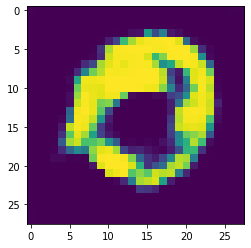

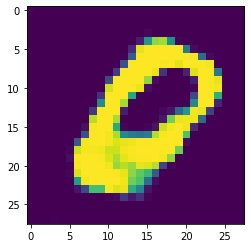

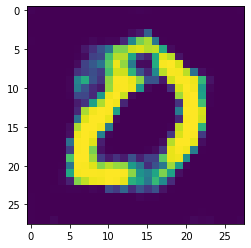

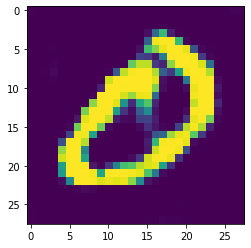

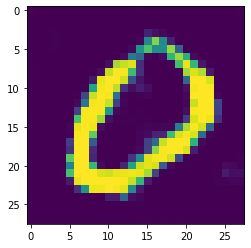

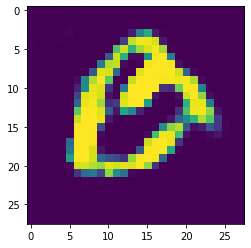

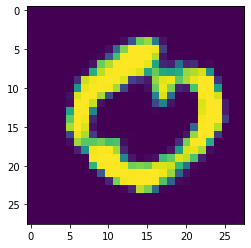

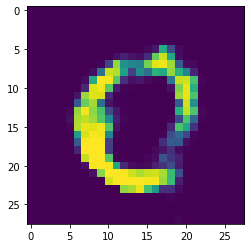

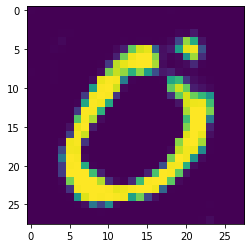

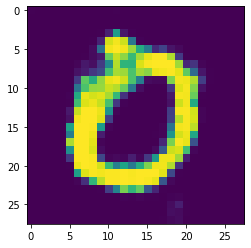

In [29]:
noise = tf.random.normal(shape=[10,codings_size])
images = generator(noise)
single_image = images[0]

for image in images:
    plt.imshow(image.numpy().reshape(28,28))
    plt.show()